In [1]:
import logging
logger = logging.getLogger('retrain_ipynb')
logger.setLevel(logging.DEBUG)


ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
formatter = logging.Formatter('%(levelname)s - %(asctime)s - %(name)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.debug('--=logging started=--')

In [2]:
import sys
TRAIN = True
IN_COLAB = 'google.colab' in sys.modules
print ('Running in colab:', IN_COLAB)

Running in colab: False


In [3]:
import os

if not IN_COLAB:
  nb_dir = os.path.split(os.getcwd())[0]
  if nb_dir not in sys.path:
      sys.path.append(nb_dir)
else:
  %tensorflow_version 1.x
  import tensorflow as tf
  print(tf.__version__)

In [4]:
if IN_COLAB:
  !pip install --upgrade pip
  !pip --version
  !pip install --no-deps --upgrade git+https://www.github.com/nemoware/analyser.git@uber-models
  !pip install -q pyjarowinkler overrides
  

In [5]:

if not IN_COLAB:
  import analyser.hyperparams  
  _work_dir_default = os.path.realpath(os.path.join(  analyser.hyperparams.__file__, '..', '..', '..', 'work'))
  work_dir = os.environ.get('GPN_WORK_DIR', _work_dir_default)
  
  if not os.path.isdir(work_dir):
    os.mkdir(work_dir)

  analyser.hyperparams.work_dir = work_dir
else:
  import analyser.hyperparams
  from google.colab import drive
  drive.mount('/content/drive')
  os.environ['GPN_WORK_DIR']='/content/drive/My Drive/GazpromOil/trainsets/uber_2'
  analyser.hyperparams.work_dir = os.environ['GPN_WORK_DIR']

print('work_dir=', analyser.hyperparams.work_dir)
assert os.path.isdir(analyser.hyperparams.work_dir)

Nemoware Analyser v2.0.2
USING WORKDIR: [/Users/artem/work/nemo/goil/nlp_tools/work]
 set ENV GPN_WORK_DIR to override
work_dir= /Users/artem/work/nemo/goil/work


/Users/artem/work/nemo/goil/nlp_tools/analyser/hyperparams.py:15: UserWarning: please set GPN_WORK_DIR environment variable
  warnings.warn('please set GPN_WORK_DIR environment variable')


# Imports

In [6]:
%matplotlib inline
import tensorflow as tf
print(tf.__version__)

 
import os
import random
import math
import json
import warnings

from os import path

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

from colab_support.renderer import *

import pickle
import numpy as np
import pandas as pd

from bson import json_util

from analyser.legal_docs import LegalDocument, make_headline_attention_vector
from analyser.headers_detector import make_predicted_headline_attention_vector, get_tokens_features
from analyser.hyperparams import models_path
from analyser.text_tools import find_top_spans
from analyser.persistence import DbJsonDoc

from trainsets.trainset_tools import TrainsetBalancer, SubjectTrainsetManager
from trainsets.retrain_contract_uber_model import UberModelTrainsetManager

from tf_support import super_contract_model
from tf_support.super_contract_model import get_base_model, seq_labels_contract
from tf_support.super_contract_model import uber_detection_model_005_1_1
from tf_support.tf_subject_model import decode_subj_prediction
from tf_support.tools import KerasTrainingContext
from tf_support.embedder_elmo import ElmoEmbedder


from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
 
from keras.models import load_model


from tensorflow import keras
import keras.backend as K
from keras.layers import Conv1D, LSTM, GRU, BatchNormalization, TimeDistributed, Dense, Bidirectional, Input, Dropout, Lambda
from keras.layers import concatenate, SpatialDropout1D, ActivityRegularization
from keras.layers import MaxPooling1D, Activation, ThresholdedReLU, GaussianNoise

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential, Model

from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences


1.15.2


Using TensorFlow backend.


loading word cases stats model from: /Users/artem/work/nemo/goil/nlp_tools/analyser/vocab/word_cases_stats.pickle
HyperParameters.subsidiary_name_match_min_jaro_similarity 0.9629629629629629


# Prepare trainset


In [7]:
if not IN_COLAB:
  from integration.db import get_mongodb_connection
  from bson.objectid import ObjectId

  def get_doc(objid):
    db = get_mongodb_connection()
    documents_collection = db['documents']
    jdata = documents_collection.find_one({'_id': ObjectId(objid)})
    return DbJsonDoc(jdata)

### Remove

In [8]:
jdoc = get_doc('5edbc59bda3678279fbcac77')
doc = jdoc.asLegalDoc()
doc.tokens

/Users/artem/work/nemo/goil/nlp_tools/integration/db.py:12: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)
/Users/artem/work/nemo/goil/nlp_tools/integration/db.py:12: UserWarning: MongoDB : define GPN_DB_HOST environment variable! defaulting to localhost
  warnings.warn(msg)
/Users/artem/work/nemo/goil/nlp_tools/integration/db.py:12: UserWarning: MongoDB : define GPN_DB_PORT environment variable! defaulting to 27017
  warnings.warn(msg)


['Договор',
 'об',
 'оказании',
 'услуг',
 '.',
 '\n',
 '№',
 'САХ-17/09000/00101/Р',
 '\n',
 '\n',
 '\n',
 '\n',
 'г.',
 'Санкт-Петербург',
 'дата',
 ':',
 '16',
 'ноября',
 '2017',
 'год',
 '\n',
 '\n',
 '\n',
 '\n',
 'Общество',
 'с',
 'ограниченной',
 'ответственностью',
 '«',
 'СДЭК-ГЛОБАЛ',
 '»',
 ',',
 'именуемое',
 'в',
 'дальнейшем',
 '«',
 'Исполнитель',
 '»',
 ',',
 'в',
 'лице',
 'Генерального',
 'директора',
 'Гольдорта',
 'Леонида',
 'Яковлевича',
 ',',
 'действующего',
 'на',
 'основании',
 'Устава',
 ',',
 'с',
 'одной',
 'Стороны',
 'и',
 'Общество',
 'с',
 'ограниченной',
 'ответственностью',
 '«',
 'Газпромнефть-Сахалин',
 '»',
 ',',
 'именуемое',
 'в',
 'дальнейшем',
 '«',
 'Клиент',
 '»',
 ',',
 'в',
 'лице',
 'Генерального',
 'директора',
 'Коробкова',
 'Александра',
 'Николаевича',
 ',',
 'действующего',
 'на',
 'основании',
 'Устава',
 ',',
 'с',
 'другой',
 'Стороны',
 ',',
 'заключили',
 'настоящий',
 'Договор',
 'о',
 'нижеследующем',
 ':',
 '\n',
 '1',
 '.',

In [10]:
umtm = UberModelTrainsetManager ( analyser.hyperparams.work_dir)

if not IN_COLAB:
#   umtm.export_docs_to_json()
  umtm.import_recent_contracts()
  umtm.calculate_samples_weights()
  umtm.validate_trainset()

I0719 07:42:04.327938 4808367552 retrain_contract_uber_model.py:253] TOTAL DATAPOINTS IN TRAINSET: 698
I0719 07:42:04.488976 4808367552 retrain_contract_uber_model.py:253] TOTAL DATAPOINTS IN TRAINSET: 698
I0719 07:42:04.517309 4808367552 retrain_contract_uber_model.py:175] latest export_date: [2020-07-03 16:14:01.459000]
I0719 07:42:04.518976 4808367552 retrain_contract_uber_model.py:177] obtaining DB connection...
I0719 07:42:04.533725 4808367552 retrain_contract_uber_model.py:180] obtaining DB connection: DONE
I0719 07:42:04.542345 4808367552 retrain_contract_uber_model.py:200] running DB query {'$and': [{'parse.documentType': 'CONTRACT'}, {'state': 15}, {'$or': [{'analysis.attributes': {'$ne': None}}, {'user.attributes': {'$ne': None}}]}, {'$or': [{'analysis.analyze_timestamp': {'$gt': Timestamp('2020-07-03 16:14:01.459000')}}, {'user.updateDate': {'$gt': Timestamp('2020-07-03 16:14:01.459000')}}]}]}
I0719 07:42:04.554157 4808367552 retrain_contract_uber_model.py:210] running DB qu

KeyboardInterrupt: 

In [11]:
umtm.stats = umtm.stats[  pd.isna(umtm.stats.value_span) + (umtm.stats.value_span < 10000) ] #remove big docs from TS

/Users/artem/work/nemo/goil/nlp_tools/venv/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "


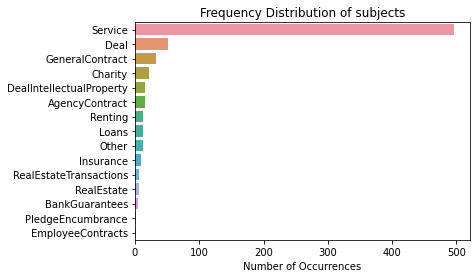


min 2
max 496
total 699


In [12]:
%matplotlib inline

subj_count = umtm.stats['subject'].value_counts()

#plot distribution---------------------
sns.barplot(subj_count.values, subj_count.index)
plt.title('Frequency Distribution of subjects')
plt.xlabel('Number of Occurrences')
plt.show()


print ('\nmin', min (subj_count.values))
print ('max', max (subj_count.values))
print ('total', sum (subj_count.values))

In [13]:
from sklearn.utils import class_weight
from trainsets.trainset_tools import get_feature_log_weights

_classes = umtm.stats['subject'].unique().tolist()

print(f'classes: {_classes}')

# class_weights = class_weight.compute_class_weight('balanced', _classes, umtm.stats['subject'])
# class_weights = dict(zip(_classes, class_weights))


class_weights = get_feature_log_weights(umtm.stats, 'subject')
class_weights

classes: ['Loans', 'Service', 'GeneralContract', 'BankGuarantees', 'Insurance', 'AgencyContract', 'RealEstateTransactions', 'Renting', 'Charity', 'PledgeEncumbrance', 'DealIntellectualProperty', 'Deal', 'RealEstate', 'Other', 'EmployeeContracts']


Service                     0.355946
Deal                        0.559298
GeneralContract             0.632038
Charity                     0.704809
DealIntellectualProperty    0.780006
AgencyContract              0.780006
Renting                     0.837392
Loans                       0.861586
Other                       0.861586
Insurance                   0.959758
RealEstateTransactions      1.135676
RealEstate                  1.135676
BankGuarantees              1.373103
PledgeEncumbrance           2.011560
EmployeeContracts           2.011560
Name: subject, dtype: float64

I0719 08:49:42.294815 4808367552 retrain_contract_uber_model.py:253] TOTAL DATAPOINTS IN TRAINSET: 700
I0719 08:49:42.504620 4808367552 retrain_contract_uber_model.py:280] docs in meta: 700
I0719 08:49:42.516274 4808367552 retrain_contract_uber_model.py:283] docs in meta after drop_duplicates: 700


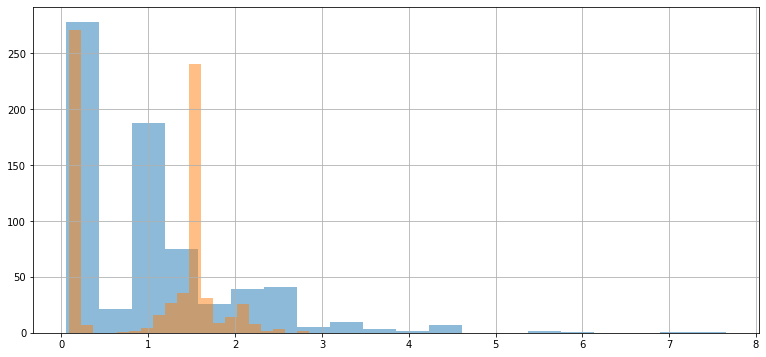

In [14]:
from trainsets.trainset_tools import get_feature_log_weights

def calculate_samples_weights(self):
  # TODO: sync with github!
  self.stats: DataFrame = self.load_contract_trainset_meta()
  if 'errors' in self.stats:
      self.stats['errors'] = umtm.stats['errors'].fillna(0)
  else:
      self.stats['errors'] = 0
  subject_weights = get_feature_log_weights(self.stats, 'subject')
  
  value_median = self.stats.value_log1p.median()

  for i, row in self.stats.iterrows():
    subj_name = row['subject']

    tagging_weight = 1.0
    if not pd.isna(row['user_correction_date']):  # MORE weight for user-corrected datapoints
      tagging_weight = 10.0  # TODO: must be estimated anyhow smartly

    value_weight = value_median
    if not pd.isna(row['value_log1p']):
      # вес пропорционален логорифму цены контракта,
      # чтобы было меньше ошибок в контрактах на большие суммы)
      value_weight = row['value_log1p']

    tagging_weight *= value_weight
    subject_weight = tagging_weight * class_weights[subj_name]

    if 'errors' in row:
      a = float( row['errors'] + 1.0)

#       ## giving more weight to incorrectly analyzed docs
#       subject_weight = subject_weight *(1.0 + row['errors'])
      tagging_weight *= a

    self.stats.at[i, 'subject_weight'] = subject_weight
    self.stats.at[i, 'sample_weight']  = tagging_weight

  # NORMALIZE weights, so the sum == Number of samples
  self.stats.sample_weight /= self.stats.sample_weight.mean()
  self.stats.subject_weight /= self.stats.subject_weight.mean()

  self._save_stats()

calculate_samples_weights(umtm)

plt.figure(figsize=(13, 6))

umtm.stats['subject_weight'].hist(bins=20, alpha=0.5)
umtm.stats['sample_weight'].hist(bins=20, alpha=0.5)

plt.xscale('linear') # log?
plt.show()

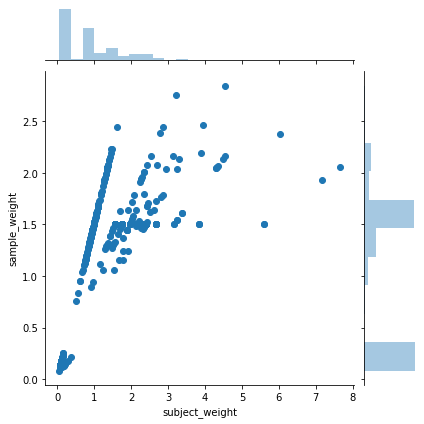

In [15]:
sns.jointplot(x="subject_weight", y="sample_weight", data=umtm.stats )
plt.show()


### look into trainset

In [93]:
# umtm.calculate_samples_weights()
SAMPLE_DOC_ID = umtm.stats.index[0]
print('SAMPLE_DOC_ID', SAMPLE_DOC_ID)
(emb, tok_f), (sm, subj), (sample_weight, subject_weight) = umtm.make_xyw(SAMPLE_DOC_ID)
 

SAMPLE_DOC_ID 5eea279dc28b75807f3dacce


semantic map shape is: (1237, 14)


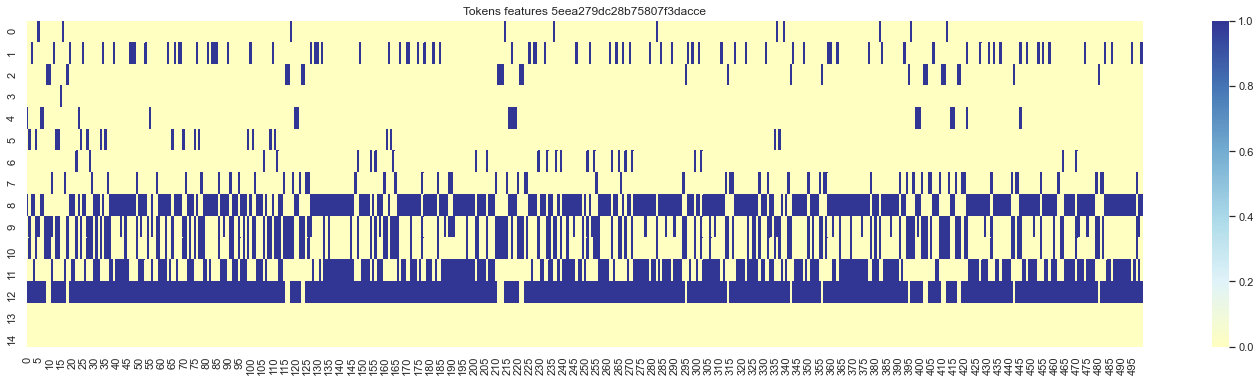

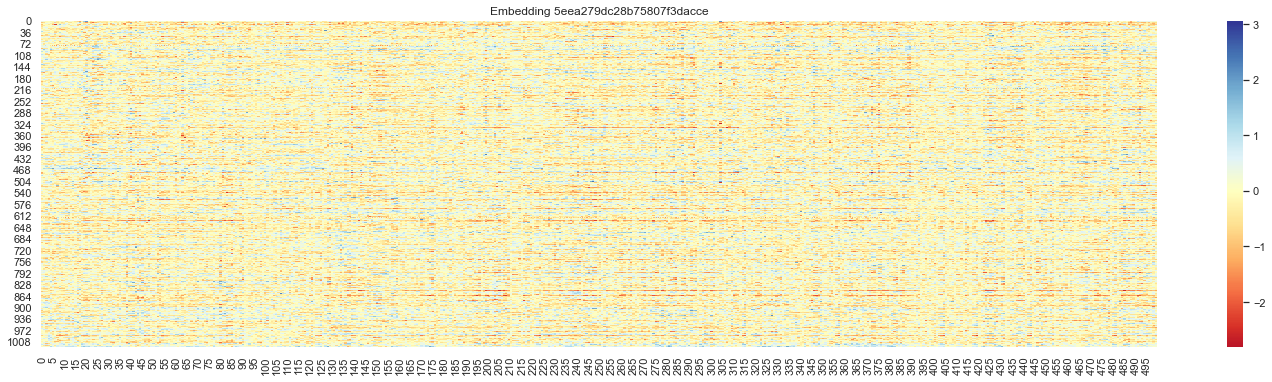

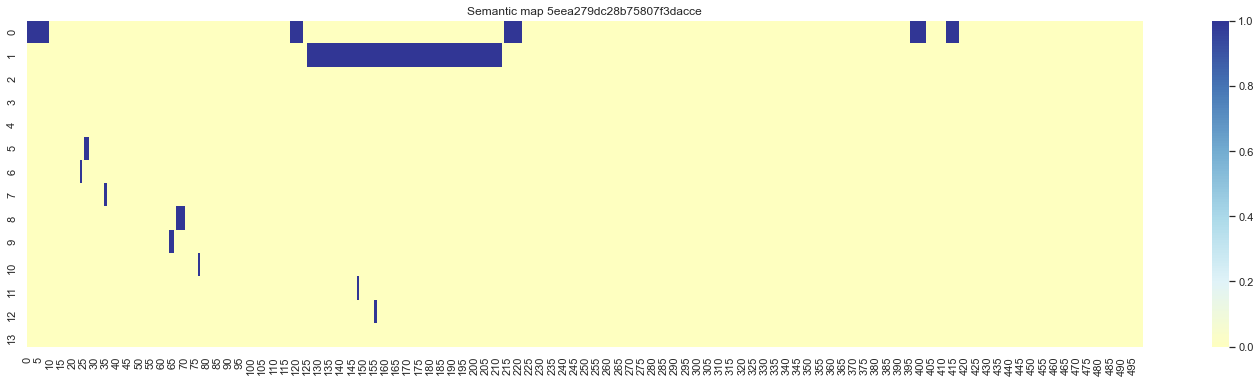

In [94]:
%matplotlib inline
print('semantic map shape is:', sm.shape)
plot_embedding(tok_f[:500], title=f'Tokens features {SAMPLE_DOC_ID}') 
plot_embedding(emb[:500], title=f'Embedding {SAMPLE_DOC_ID}') 
plot_embedding(sm[:500], title=f'Semantic map {SAMPLE_DOC_ID}')

## Batch generator & TODOs 🙏


- [X] TODO: add outliers to the trainset ?
- [ ] TODO: try sparse_categorical_entropy instead of one-hot encodings
- [ ] TODO: model 5.2, 5.1: bipolar concat layer is wrong because we concatenate thongs of different magnitudes. Add a Sigmoid activation layer
- [ ] TODO: chechk what is better: to pad with zeros or to pad with means
- [X] TODO: add weights to samples
- [ ] TODO: sum semantic map alongside vertical axis, and mutiply it (as a mask) by the subject detection seq
- [ ] TODO: introduce individual per tag threshosholds, also, the current 0.3 threshold is strange.

In [18]:
def make_generator(self, indices: [int], batch_size: int, augment_samples=False):

  np.random.seed(42)

  while True:
    # next batch
    batch_indices = np.random.choice(a=indices, size=batch_size)

    max_len = 128 * 12
    start_from = 0

    if augment_samples:
      max_len =  random.randint(300, 1400)

    batch_input_emb = []
    batch_input_token_f = []
    batch_output_sm = []
    batch_output_subj = []

    weights = []
    weights_subj = []

    # Read in each input, perform preprocessing and get labels
    for doc_id in batch_indices:

      dp = self.make_xyw(doc_id)
      (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp

      subject_weight_K=1.0
      if augment_samples:
        start_from = 0
        
        row = self.stats.loc[doc_id]
        if random.randint(1, 2) == 1:  # 50% of samples
          segment_center = random.randint(0, len(emb)-1) ##select random token as a center
          if not pd.isna(row['value_span']) and random.random()<0.7:        
            segment_center = int(row['value_span'])

          _off = random.randint(max_len // 4, max_len // 2)
          start_from = segment_center - _off
          if start_from < 0:
            start_from = 0
          subject_weight_K = 0.1 #lower subject weight because there mighе be no information about subject around doc. value

      dp = self.trim_maxlen(dp, start_from, max_len)
      # TODO: find samples maxlen

      (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp
      subject_weight *= subject_weight_K

      batch_input_emb.append(emb)
      batch_input_token_f.append(tok_f)

      batch_output_sm.append(sm)
      batch_output_subj.append(subj)

      weights.append(sample_weight)
      weights_subj.append(subject_weight)
      # end if emb
    # end for loop

    # Return a tuple of (input, output, weights) to feed the network
    yield ([np.array(batch_input_emb), np.array(batch_input_token_f)],
            [np.array(batch_output_sm), np.array(batch_output_subj)],
            [np.array(weights), np.array(weights_subj)])

train_indices[0]: 5ee832322281f29204c52c2d
test_indices[0]: 5eea2799c28b75807f3dac7c
X: 2 X[0]= (24, 513, 1024) X[1]= (24, 513, 15)
Y: 2 Y[0]= (24, 513, 14) Y[1]= (24, 43)


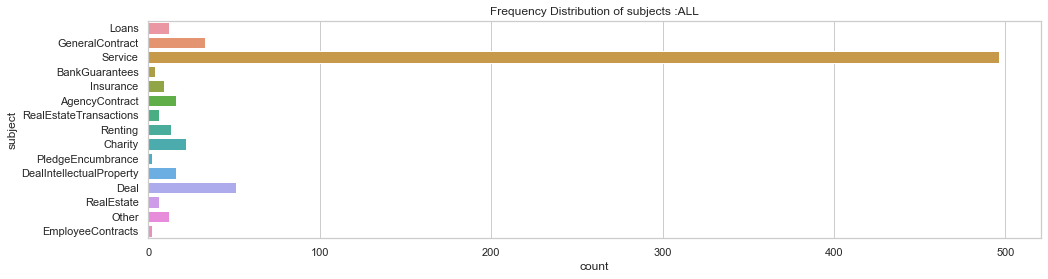

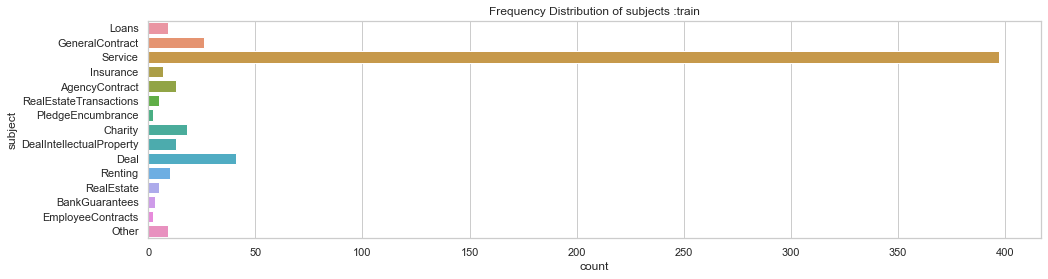

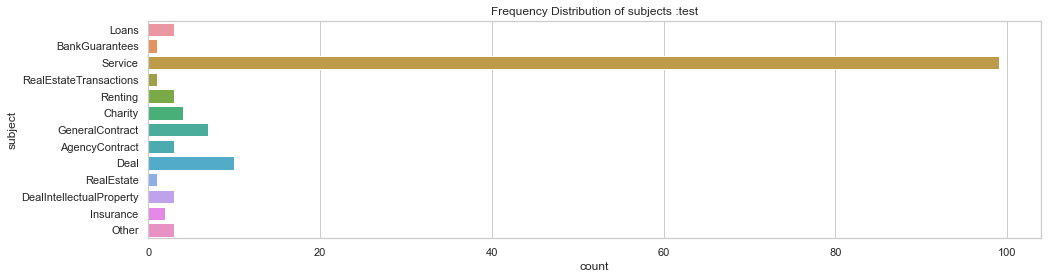

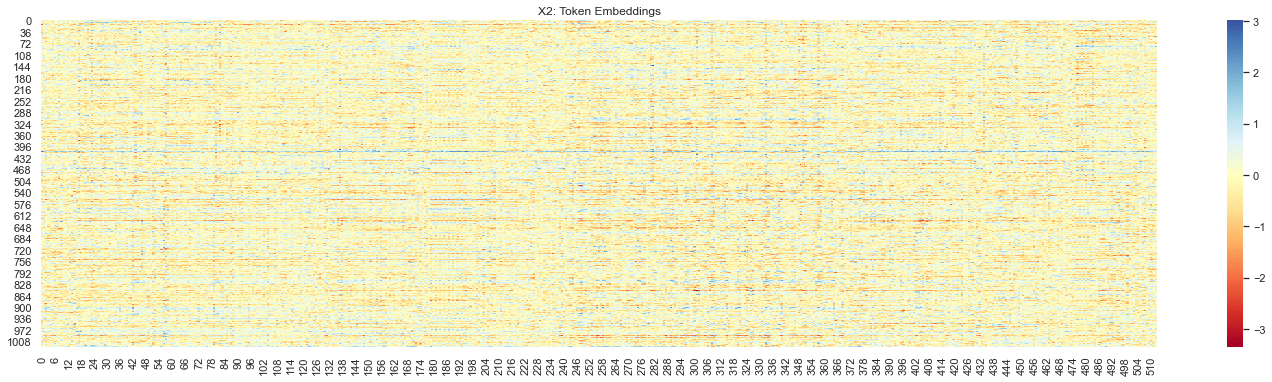

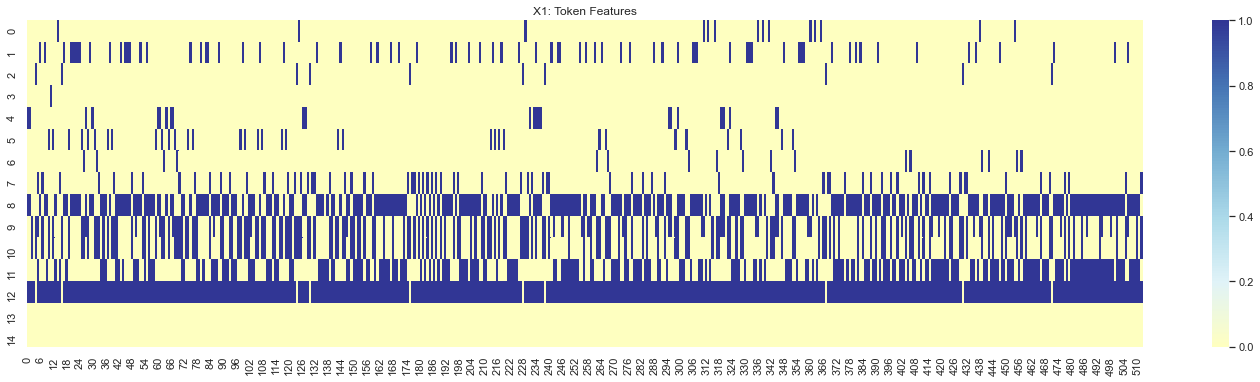

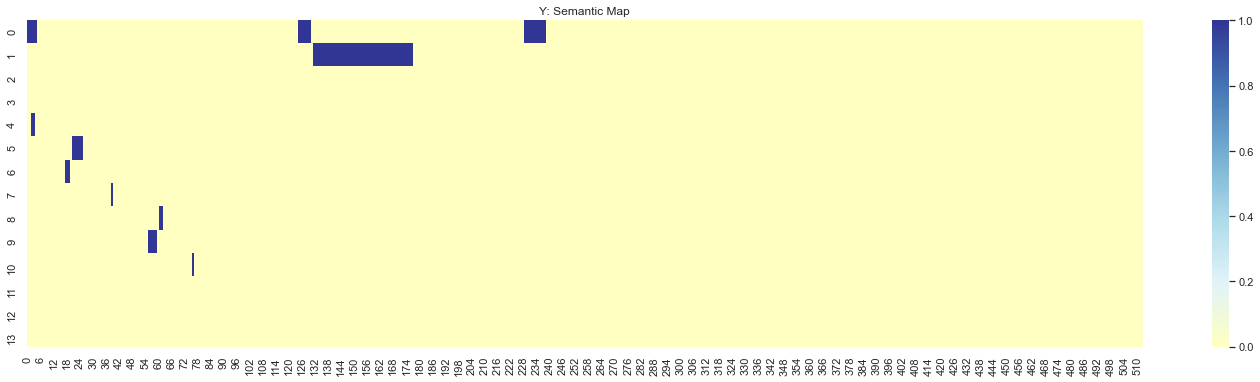

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [19]:
EPOCHS = 50
BATCH_SIZE = 24
EMB =  1024
 
_SELFTEST = True


_train, _test = train_test_split(umtm.stats, test_size=0.2, stratify=umtm.stats[['subject']])
train_indices = list(_train.index)
test_indices = list(_test.index)


print('train_indices[0]:', train_indices[0])
print('test_indices[0]:', test_indices[0])


def plot_subject_distr(df, title):  
  target='subject'
  plt.figure(figsize=(16,4))   
  sns.set(style="whitegrid")
  chart = sns.countplot(data=df, y=target)
  plt.title(f'Frequency Distribution of subjects :{title}')

 
plot_subject_distr(umtm.stats, 'ALL')
plot_subject_distr(umtm.stats[umtm.stats.index.isin(train_indices)], 'train')
plot_subject_distr(umtm.stats[umtm.stats.index.isin(test_indices)], 'test')


if _SELFTEST:
  # test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True)
  
  x, y, w = next(train_gen)
  
  print('X:', len(x), 'X[0]=', x[0].shape, 'X[1]=', x[1].shape)
  print('Y:', len(y), 'Y[0]=', y[0].shape, 'Y[1]=', y[1].shape)
  

  plot_embedding(x[0][0], 'X2: Token Embeddings')
  plot_embedding(x[1][0], 'X1: Token Features')
  plot_embedding(y[0][0], 'Y: Semantic Map')
  
  print(y[0][1])

  del x
  del w
  del y
  del train_gen

In [20]:

ctx = KerasTrainingContext(umtm.work_dir, session_index=21)

ctx.set_batch_size_and_trainset_size(BATCH_SIZE, 
                                     len(test_indices), 
                                     4 * len(train_indices))

DEFAULT_TRAIN_CTX = ctx
CLASSES = 43
FEATURES = 14

metrics = ['kullback_leibler_divergence', 'mse', 'binary_crossentropy']


def train(umodel):
  test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen)

def overtrain(umodel):
  test_gen = make_generator(umtm, list(train_indices) + list(test_indices), BATCH_SIZE)
  train_gen = make_generator(umtm, list(train_indices) + list(test_indices), BATCH_SIZE, augment_samples=True) 
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen)


batch_size:	24
train_samples:	2240
test_samples:	140
steps_per_epoch:	93
validation_steps:	46


In [21]:
def init_model(model_fn) -> (Model, KerasTrainingContext):
  model_name = model_fn.__name__
  model = model_fn(name=model_name, ctx=ctx, trained=True)
  model.name = model_name

  weights_file_old = os.path.join(models_path, model_name + ".weights")
  weights_file_new = os.path.join(umtm.work_dir, model_name + ".weights")

  try:
    model.load_weights(weights_file_new, by_name=True )
    logger.info(f'weights loaded: {weights_file_new}')

  except:
    msg = f'cannot load  {model_name} from  {weights_file_new}'
    warnings.warn(msg)
    logger.warning(msg)
    model.load_weights(weights_file_old, by_name=True )
    logger.info(f'weights loaded: {weights_file_old}')

  # freeze bottom 6 layers, including 'embedding_reduced' #TODO: this must be model-specific parameter
  for l in model.layers[0:6]:
    l.trainable = False

  model.compile(loss=super_contract_model.losses, optimizer='Nadam', metrics=super_contract_model.metrics)
  model.summary()

  return model




# Models 🦖

### 5.1.1 💕💕 uber_detection_model_005_1_1

In [22]:
umodel = init_model(uber_detection_model_005_1_1)

W0719 08:50:12.259475 4808367552 deprecation.py:506] From /Users/artem/work/nemo/goil/nlp_tools/venv/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
W0719 08:50:13.641041 4808367552 module_wrapper.py:139] From /Users/artem/work/nemo/goil/nlp_tools/venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

INFO - 2020-07-19 08:50:19,481 - retrain_ipynb - weights loaded: /Users/artem/work/nemo/goil/work/uber_detection_model_005_1_1.weights
I0719 08:50:19.481086 4808367552 <ipython-input-21-efc5081f7da4>:11] weights loaded: /Users/artem/work/nemo/goil/work/uber_detection_model_005_1_1.weights


Model: "uber_detection_model_005_1_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text_emb (InputLayer)     (None, None, 1024)   0                                            
__________________________________________________________________________________________________
drops (Dropout)                 (None, None, 1024)   0           input_text_emb[0][0]             
__________________________________________________________________________________________________
input_headlines_att (InputLayer (None, None, 15)     0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, None, 1039)   0           drops[0][0]                      
                                                                 input_

In [ ]:
######################
# Phase I retraining
# ❄️ frozen bottom layers
######################

if TRAIN:
  test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

  ctx.EPOCHS = 25
  ctx.EVALUATE_ONLY = False
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

model.name == uber_detection_model_005_1_1
continue: lr:0.0020000000949949026, epoch:0


W0719 08:50:20.536344 4808367552 deprecation.py:323] From /Users/artem/work/nemo/goil/nlp_tools/venv/lib/python3.7/site-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0719 08:50:22.887962 4808367552 module_wrapper.py:139] From /Users/artem/work/nemo/goil/nlp_tools/venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Epoch 1/25
93/93 [==============================] - 309s 3s/step - loss: 0.0120 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0070 - O1_tagging_kullback_leibler_divergence: 0.0338 - O1_tagging_mse: 9.7733e-04 - O1_tagging_binary_crossentropy: 0.0047 - O2_subject_kullback_leibler_divergence: 0.3433 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0133 - val_loss: 0.0228 - val_O1_tagging_loss: 0.0039 - val_O2_subject_loss: 0.0065 - val_O1_tagging_kullback_leibler_divergence: 0.0238 - val_O1_tagging_mse: 5.9996e-04 - val_O1_tagging_binary_crossentropy: 0.0036 - val_O2_subject_kullback_leibler_divergence: 0.0859 - val_O2_subject_mse: 8.0674e-04 - val_O2_subject_binary_crossentropy: 0.0035

Epoch 00001: val_loss improved from inf to 0.02284, saving model to /Users/artem/work/nemo/goil/work/uber_detection_model_005_1_1.weights
Epoch 2/25
92/93 [============================>.] - ETA: 2s - loss: 0.0110 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0062 - O1_tagging_kullback_leibl

In [50]:
######################
## Phase II finetuning
#  all unfrozen, entire trainset, low LR
######################
if TRAIN:
  ctx.unfreezeModel(umodel)
  umodel.compile(loss=super_contract_model.losses, optimizer='Nadam', metrics=super_contract_model.metrics)
  umodel.summary()

  ctx.EPOCHS *= 2

  test_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE, augment_samples=True) 
  
  ctx.train_and_evaluate_model(umodel, train_gen, test_generator=test_gen, retrain=False, lr=2e-5)

Model: "uber_detection_model_005_1_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text_emb (InputLayer)     (None, None, 1024)   0                                            
__________________________________________________________________________________________________
drops (Dropout)                 (None, None, 1024)   0           input_text_emb[0][0]             
__________________________________________________________________________________________________
input_headlines_att (InputLayer (None, None, 15)     0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, None, 1039)   0           drops[0][0]                      
                                                                 input_

93/93 [==============================] - 255s 3s/step - loss: 0.0097 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0049 - O1_tagging_kullback_leibler_divergence: 0.0310 - O1_tagging_mse: 8.6263e-04 - O1_tagging_binary_crossentropy: 0.0045 - O2_subject_kullback_leibler_divergence: 0.2931 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0116 - val_loss: 0.0140 - val_O1_tagging_loss: 0.0048 - val_O2_subject_loss: 0.0076 - val_O1_tagging_kullback_leibler_divergence: 0.0240 - val_O1_tagging_mse: 6.2520e-04 - val_O1_tagging_binary_crossentropy: 0.0042 - val_O2_subject_kullback_leibler_divergence: 0.1031 - val_O2_subject_mse: 0.0012 - val_O2_subject_binary_crossentropy: 0.0043

Epoch 00056: val_loss did not improve from 0.00491
Epoch 57/100
93/93 [==============================] - 245s 3s/step - loss: 0.0103 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0055 - O1_tagging_kullback_leibler_divergence: 0.0299 - O1_tagging_mse: 8.5127e-04 - O1_tagging_binary_crossentropy: 0.0046 - O


Epoch 00066: val_loss did not improve from 0.00491
Epoch 67/100
93/93 [==============================] - 241s 3s/step - loss: 0.0104 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0054 - O1_tagging_kullback_leibler_divergence: 0.0328 - O1_tagging_mse: 9.0381e-04 - O1_tagging_binary_crossentropy: 0.0048 - O2_subject_kullback_leibler_divergence: 0.3541 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0135 - val_loss: 0.0052 - val_O1_tagging_loss: 0.0041 - val_O2_subject_loss: 0.0095 - val_O1_tagging_kullback_leibler_divergence: 0.0254 - val_O1_tagging_mse: 6.4550e-04 - val_O1_tagging_binary_crossentropy: 0.0039 - val_O2_subject_kullback_leibler_divergence: 0.1173 - val_O2_subject_mse: 0.0014 - val_O2_subject_binary_crossentropy: 0.0049

Epoch 00067: val_loss did not improve from 0.00491
Epoch 68/100
93/93 [==============================] - 250s 3s/step - loss: 0.0100 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0052 - O1_tagging_kullback_leibler_divergence: 0.0315 - O1_tag

93/93 [==============================] - 249s 3s/step - loss: 0.0114 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0063 - O1_tagging_kullback_leibler_divergence: 0.0351 - O1_tagging_mse: 9.6443e-04 - O1_tagging_binary_crossentropy: 0.0048 - O2_subject_kullback_leibler_divergence: 0.3286 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0131 - val_loss: 0.0060 - val_O1_tagging_loss: 0.0041 - val_O2_subject_loss: 0.0047 - val_O1_tagging_kullback_leibler_divergence: 0.0214 - val_O1_tagging_mse: 6.1103e-04 - val_O1_tagging_binary_crossentropy: 0.0037 - val_O2_subject_kullback_leibler_divergence: 0.0603 - val_O2_subject_mse: 5.5421e-04 - val_O2_subject_binary_crossentropy: 0.0026

Epoch 00077: val_loss did not improve from 0.00327
Epoch 78/100
93/93 [==============================] - 225s 2s/step - loss: 0.0106 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0059 - O1_tagging_kullback_leibler_divergence: 0.0328 - O1_tagging_mse: 9.3392e-04 - O1_tagging_binary_crossentropy: 0.0046


Epoch 00087: val_loss did not improve from 0.00327
Epoch 88/100
93/93 [==============================] - 260s 3s/step - loss: 0.0110 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0059 - O1_tagging_kullback_leibler_divergence: 0.0318 - O1_tagging_mse: 8.7142e-04 - O1_tagging_binary_crossentropy: 0.0048 - O2_subject_kullback_leibler_divergence: 0.3512 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0136 - val_loss: 0.0105 - val_O1_tagging_loss: 0.0040 - val_O2_subject_loss: 0.0063 - val_O1_tagging_kullback_leibler_divergence: 0.0221 - val_O1_tagging_mse: 5.9041e-04 - val_O1_tagging_binary_crossentropy: 0.0038 - val_O2_subject_kullback_leibler_divergence: 0.0864 - val_O2_subject_mse: 9.4734e-04 - val_O2_subject_binary_crossentropy: 0.0036

Epoch 00088: val_loss did not improve from 0.00327
Epoch 89/100
93/93 [==============================] - 235s 3s/step - loss: 0.0108 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0055 - O1_tagging_kullback_leibler_divergence: 0.0335 - O1


Epoch 00098: val_loss did not improve from 0.00327
Epoch 99/100
93/93 [==============================] - 321s 3s/step - loss: 0.0103 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0054 - O1_tagging_kullback_leibler_divergence: 0.0329 - O1_tagging_mse: 9.0885e-04 - O1_tagging_binary_crossentropy: 0.0048 - O2_subject_kullback_leibler_divergence: 0.3636 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0139 - val_loss: 0.0098 - val_O1_tagging_loss: 0.0044 - val_O2_subject_loss: 0.0070 - val_O1_tagging_kullback_leibler_divergence: 0.0229 - val_O1_tagging_mse: 6.1110e-04 - val_O1_tagging_binary_crossentropy: 0.0038 - val_O2_subject_kullback_leibler_divergence: 0.0972 - val_O2_subject_mse: 0.0011 - val_O2_subject_binary_crossentropy: 0.0041

Epoch 00099: val_loss did not improve from 0.00327
Epoch 100/100
93/93 [==============================] - 284s 3s/step - loss: 0.0108 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0059 - O1_tagging_kullback_leibler_divergence: 0.0340 - O1_ta

# Evaluate models

In [51]:
umodel = ctx.init_model(uber_detection_model_005_1_1, trained=True)

weights loaded: /Users/artem/work/nemo/goil/work/uber_detection_model_005_1_1.weights


### training history

loading training log from /Users/artem/work/nemo/goil/work/uber_detection_model_005_1_1.21.log.csv


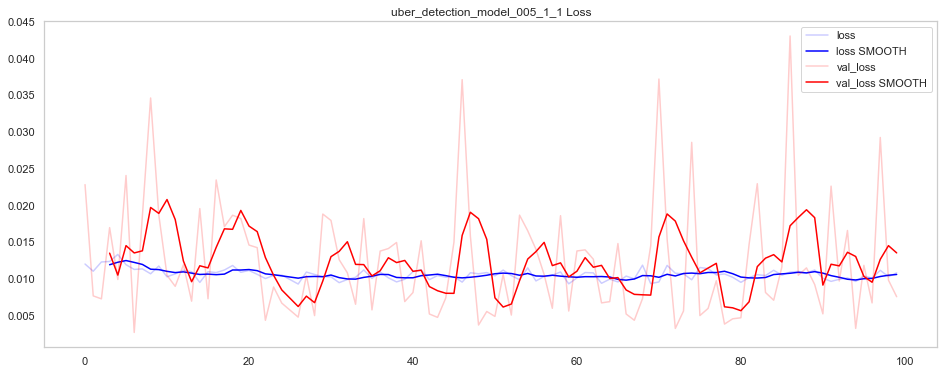

loading training log from /Users/artem/work/nemo/goil/work/uber_detection_model_005_1_1.21.log.csv


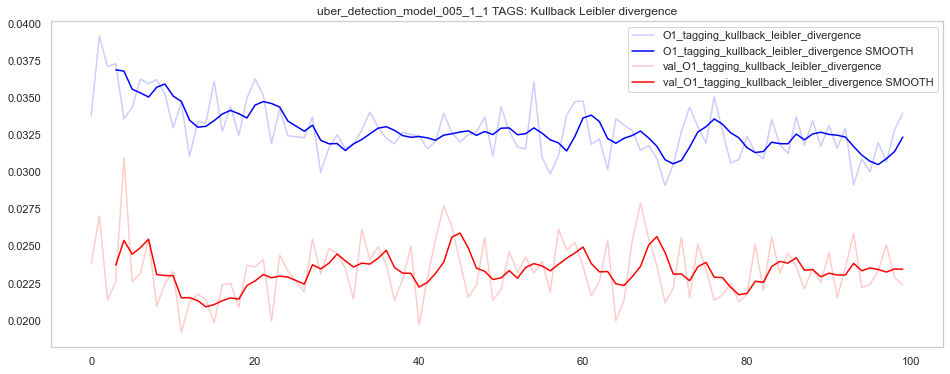

loading training log from /Users/artem/work/nemo/goil/work/uber_detection_model_005_1_1.21.log.csv


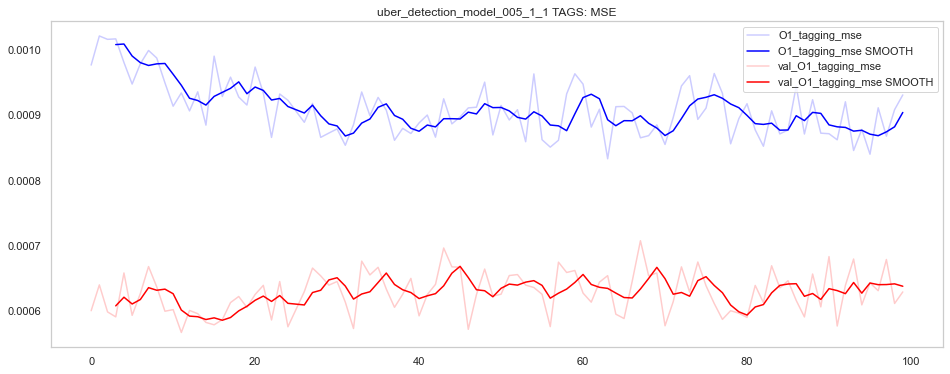

loading training log from /Users/artem/work/nemo/goil/work/uber_detection_model_005_1_1.21.log.csv


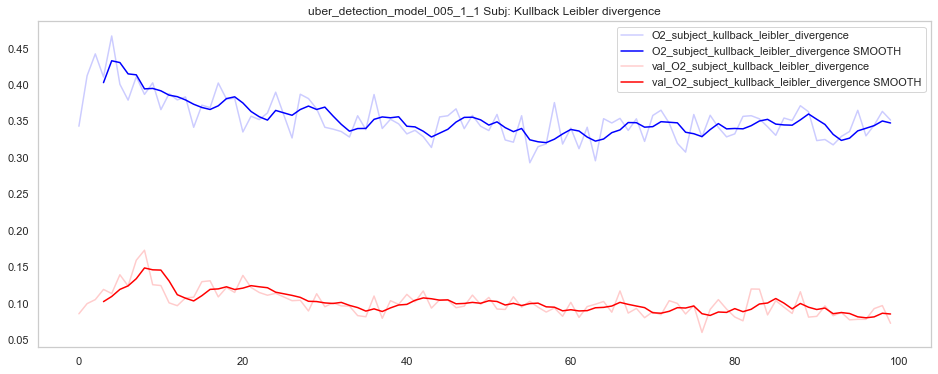

loading training log from /Users/artem/work/nemo/goil/work/uber_detection_model_005_1_1.21.log.csv


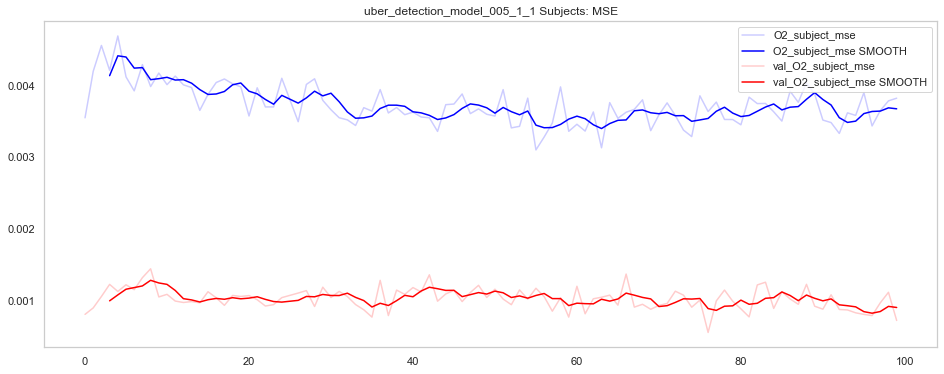

loading training log from /Users/artem/work/nemo/goil/work/uber_detection_model_005_1_1.21.log.csv


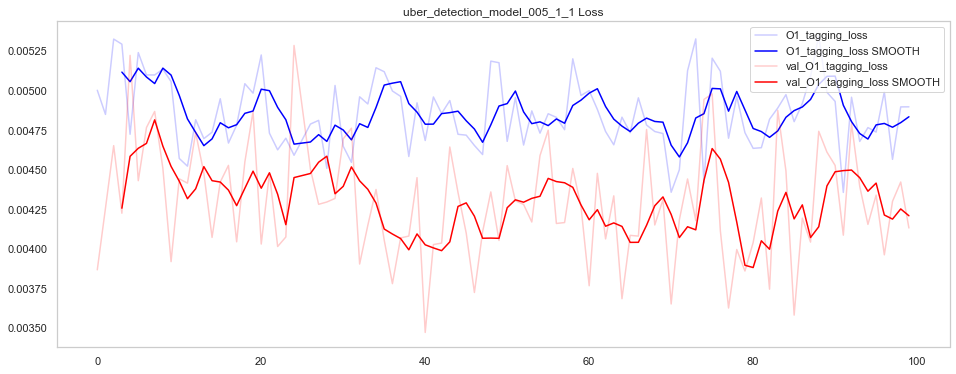

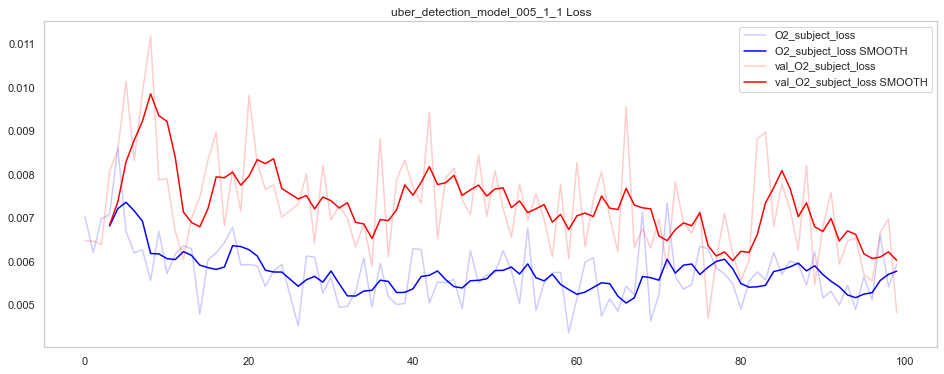

In [52]:
def plot_compare_models(
    models: [str],
    metrics, 
    title="metric/epoch",
    image_save_path = umtm.work_dir):
    
  _metrics = [m for m in metrics if not m.startswith('val_')]

  for i, m in enumerate(models):

    data: pd.DataFrame = ctx.get_log(m)

    if data is not None:
      data.set_index('epoch')

      for metric in _metrics:
        plt.figure(figsize=(16, 6))
        plt.grid()
        plt.title(f'{metric}')
        for metric_variant in ['', 'val_']:
          key = metric_variant + metric
          if key in data:

            x = data['epoch'][-100:]
            y = data[key][-100:]


            c = 'red'  # plt.cm.jet_r(i * colorstep)
            if metric_variant == '':
              c = 'blue'
            plt.plot(x, y, label=f'{key}', alpha=0.2, color=c)

            y = y.rolling(4, win_type='gaussian').mean(std=4)
            plt.plot(x, y, label=f'{key} SMOOTH', color=c)

            plt.legend(loc='upper right')

        
        plt.title(f'{m} {title}')
        plt.grid()
        img_path = os.path.join(image_save_path, f'{m}-{metric}.png')
        plt.savefig(img_path, bbox_inches='tight')
        plt.grid()
        plt.show()
    else:
      logger.error('cannot plot')
    

models = list(ctx.trained_models.keys())


plot_compare_models(models, ['loss'], 'Loss')

plot_compare_models(models, ['O1_tagging_kullback_leibler_divergence'], 'TAGS: Kullback Leibler divergence')
plot_compare_models(models, ['O1_tagging_mse'], 'TAGS: MSE')
plot_compare_models(models, ['O2_subject_kullback_leibler_divergence'], 'Subj: Kullback Leibler divergence')
plot_compare_models(models, ['O2_subject_mse'],  'Subjects: MSE')

plot_compare_models(models, ['O1_tagging_loss', 'O2_subject_loss'], 'Loss')

## Contract subj Confusion matrices

In [92]:
from pandas import DataFrame

from analyser.contract_agents import ContractAgent, normalize_contract_agent
from analyser.documents import TextMap
from analyser.ml_tools import SemanticTag
from analyser.persistence import DbJsonDoc
from analyser.text_tools import find_top_spans
from tf_support.super_contract_model import seq_labels_contract
from tf_support.tf_subject_model import decode_subj_prediction

from analyser.contract_parser import nn_find_org_names, nn_get_tag_value



# def fetch_tag_value(tagname: str, textmap: TextMap, tagging: DataFrame, threshold=0.3) -> SemanticTag or None:
#   att = tagging[tagname].values
#   slices = find_top_spans(att, threshold=threshold, limit=1) #TODO: estimate per-tag thresholds
  
#   if len(slices) > 0:
#     span = slices[0].start, slices[0].stop
#     value = textmap.text_range(span)
#     tag = SemanticTag(tagname, value, span)
#     tag.confidence = att[slices[0]].mean()
#     return tag
#   return None


agent_tags = ['org-1-name',
              'org-1-type',
              'org-1-alias',
              'org-2-name',
              'org-2-type',
              'org-2-alias']
solo_tags = [
  'date',
  'number',
  'sign_value_currency/value',
  'sign_value_currency/currency',
  'sign_value_currency/sign'
]
tagnames = solo_tags + agent_tags


def fetch_tags_from_predicted_semantic_map(_id: str, tagsmap: DataFrame):
  jdoc = get_doc(_id)
  _map = jdoc.get_tokens_map_unchaged()

  results = {}
  for key in tagnames:
    t = nn_get_tag_value(key, _map, tagsmap )
    results[key] = t
    # print(t)

#   ca = ContractAgent()
#   ca.name =  results['org-1-name'] #TODO: check for NONE
#   ca.type =  results['org-1-type']
#   ca.alias = results['org-1-alias']
   

#   ca2 = ContractAgent()
#   ca2.name =  results['org-2-name'] #TODO: check for NONE
#   ca2.type =  results['org-2-type']
#   ca2.alias = results['org-2-alias']
#   try:
#     normalize_contract_agent(ca)
#     normalize_contract_agent(ca2)
#   except Exception as e:
#         # TODO:
#     logger.error(f'{_id} {e}')

  if results['number'] is not None:
    results['number'].value = results['number'].value.strip().lstrip('№').lstrip('N ').lstrip()

  return results, jdoc


def put_results_into_df(id_, results, df, jdoc: DbJsonDoc):
  org_atribs = ['name', 'alias', 'type']

  def v(x):
    if results[x] is not None:
      return results[x].value

  def swap(a, b):
    ab = [a, b]
    try:
      ab = sorted(ab)
    except:
      pass
    return ab

  def s(a, b):
    ab = swap(v(a), v(b))
    df.at[id_, f'p-{a}'] = ab[0]
    df.at[id_, f'p-{b}'] = ab[1]
    return ab

  for key in org_atribs:
    arr = s(f'org-1-{key}', f'org-2-{key}')

  def p(key):
    df.at[id_, f'p-{key}'] = v(key)

  p('sign_value_currency/value')
  p('sign_value_currency/currency')
  p('sign_value_currency/sign')

  p('date')
  p('number')

  # get_expected values
  for key in solo_tags:
    t = jdoc.get_attribute_value(key)
    df.at[id_, f'{key}'] = t

  for key in org_atribs:
    orgs = swap(jdoc.get_attribute_value(f'org-1-{key}'), jdoc.get_attribute_value(f'org-2-{key}'))
    df.at[id_, f'org-1-{key}'] = orgs[0]
    df.at[id_, f'org-2-{key}'] = orgs[1]


def make_subj_predictions(umodel, indices):
  ev = umtm.stats.copy()
  tags = pd.DataFrame()
  for t in tagnames:
    tags['p-' + t] = ''
    tags[t] = ''

  errors_report = pd.DataFrame()
  errors_report['expected'] = ''
  errors_report['predicted'] = ''

  for i, _id in enumerate(indices):
    logger.debug(f'validating {_id} {i} of {len(indices)}')
    
    x, y, _ = umtm.make_xyw(_id)

    prediction = umodel.predict(x=[np.expand_dims(x[0], axis=0), np.expand_dims(x[1], axis=0)], batch_size=1)

    tagsmap = pd.DataFrame(prediction[0][0], columns=seq_labels_contract)
  
    r, jdoc = fetch_tags_from_predicted_semantic_map(_id, tagsmap)
    put_results_into_df(_id, r, tags, jdoc)
    

    subj_1hot = prediction[1][0]

    expected = decode_subj_prediction(y[1])[0]
    predicted = decode_subj_prediction(subj_1hot)[0]

    ev.at[_id, 'expected_subj'] = expected.name
    ev.at[_id, 'predicted_subj'] = predicted.name

    ev.at[_id, 'wrong'] = False
    if expected != predicted:
      ev.at[_id, 'wrong'] = True

  return ev, tags


subset = umtm.stats #umtm.stats[~pd.isna(umtm.stats['user_correction_date'])].sort_values('analyze_date')
_indices =  subset.index
ev, tags = make_subj_predictions(umodel, _indices)
tags.to_csv('all_contracts_predicstions.csv')

I0720 14:38:03.015662 4808367552 <ipython-input-92-9bb10209e7ac>:134] validating 5eea279dc28b75807f3dacce 0 of 700
I0720 14:38:03.250456 4808367552 <ipython-input-46-bcc853bcabe7>:14] fetching 5eea279dc28b75807f3dacce
I0720 14:38:03.305655 4808367552 <ipython-input-92-9bb10209e7ac>:134] validating 5eea27adc28b75807f3dae66 1 of 700
I0720 14:38:07.215802 4808367552 <ipython-input-46-bcc853bcabe7>:14] fetching 5eea27adc28b75807f3dae66
I0720 14:38:11.199171 4808367552 <ipython-input-92-9bb10209e7ac>:134] validating 5efe9252777d4b67a92d561b 2 of 700
I0720 14:38:13.309848 4808367552 <ipython-input-46-bcc853bcabe7>:14] fetching 5efe9252777d4b67a92d561b
I0720 14:38:13.853746 4808367552 <ipython-input-92-9bb10209e7ac>:134] validating 5efe924d777d4b67a92d55b1 3 of 700
I0720 14:38:15.826937 4808367552 <ipython-input-46-bcc853bcabe7>:14] fetching 5efe924d777d4b67a92d55b1
I0720 14:38:16.220225 4808367552 <ipython-input-92-9bb10209e7ac>:134] validating 5eea279dc28b75807f3daccb 4 of 700
I0720 14:38:1

TypeError: 'NoneType' object is not iterable

In [77]:
# subset = umtm.stats[~pd.isna(umtm.stats['user_correction_date'])]
# pd.isna(umtm.stats['user_correction_date'])
ev 

,export_date,subject,org-1-alias,org-2-alias,checksum,version,analyze_date,value,value_log1p,value_span,subject confidence,user_correction_date,valid,errors,subject_weight,sample_weight,error,expected_subj,predicted_subj,wrong
_id,,,,,,,,,,,,,,,,,,,,
5eea279dc28b75807f3dacce,2020-07-02 13:15:11.351819,Loans,Заемщик,Займодавец,a2fd74d33e546dc0fde7ae1d50eb3cae,1.22.1,2020-06-30 21:27:54.865,6.040500e+10,24.824338,148.0,0.997801,2020-06-17 15:44:57.491,True,0.0,4.541809,2.847666,NaN,Loans,Loans,False
5eea27adc28b75807f3dae66,2020-07-02 13:15:53.723054,GeneralContract,Заказчик/ЗАКАЗЧИК,Подрядчик/ПОДРЯДЧИК/ЕРС-Подрядчик,8a9ce8cea53e54a03caa5c252ad2bb7b,1.22.1,2020-06-30 22:19:35.189,2.807709e+10,24.058220,21847.0,0.955438,2020-06-19 05:39:50.512,True,0.0,3.228933,2.759782,NaN,GeneralContract,GeneralContract,False
5efe9252777d4b67a92d561b,2020-07-19 07:46:40.165507,Service,Заказчик,Исполнитель,456ced6347abbe28d6f831db2031799a,2.0.0,2020-07-03 16:32:14.038,2.661621e+09,21.702201,8043.0,0.998380,NaT,False,0.0,0.164037,0.248952,NaN,Service,Service,False
5efe924d777d4b67a92d55b1,2020-07-19 02:22:58.250844,Service,Заказчик,Исполнитель,5b81a5fb7dddb04565fe33b27ecbcee7,2.0.0,2020-07-03 15:29:34.985,2.580136e+09,21.671108,8160.0,0.980345,NaT,False,0.0,0.163802,0.248595,NaN,Service,Service,False
5eea279dc28b75807f3daccb,2020-07-02 13:15:11.091052,Loans,Займодавец,Заемщик,839bd7f3a1a443ffdf00c200788df8b3,1.22.1,2020-06-30 21:27:51.400,2.215000e+09,21.518518,159.0,0.973850,2020-06-17 15:45:57.928,True,0.0,3.936983,2.468446,NaN,Loans,Loans,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5edbc65dda3678279fbcae68,2020-07-02 13:13:55.965525,Service,Заказчик,,e6050d7bfaa96e7a8b283c36c4490687,1.22.1,2020-06-30 20:08:00.030,NaN,NaN,NaN,0.994054,NaT,True,0.0,0.099186,0.150530,NaN,Service,Service,False
5edbc5a9da3678279fbcad29,2020-07-02 13:13:45.263897,Service,,,4e9bbffec18a5ce4417ea091ed871979,1.22.1,2020-06-30 19:49:34.496,NaN,NaN,NaN,0.998208,NaT,True,0.0,0.099186,0.150530,NaN,Service,Service,False
5edbadd7da3678279fbcaabd,2020-07-02 13:13:38.675092,Service,Заказчик,Исполнитель,f41c6fe54622dc70f276d07d7a1f86a1,1.22.1,2020-06-30 19:40:11.446,NaN,NaN,NaN,0.991027,NaT,True,0.0,0.099186,0.150530,NaN,Service,Service,False


In [83]:
# _cols = [  'wrong' ]
# _tmp = ev[cols]
# errors_report = _tmp[ _tmp.wrong == True] #.sort_values('subject')
# print(len(errors_report), 'wrong subjects of', len(tags))
# errors_report 

ev['predicted_subj']
subj_df = ev[['predicted_subj', 'expected_subj']].copy()

AssertionError: Number of manager items must equal union of block items
# manager items: 20, # tot_items: 21

In [82]:
def make_report(umodel, ev):
  plot_cm(ev['expected_subj'], ev['predicted_subj'])
  
  img_path = os.path.join(umtm.work_dir, f'subjects-confusion-matrix-{umodel.name}.png')
  plt.savefig(img_path, bbox_inches='tight')

  report = classification_report(ev['expected_subj'], ev['predicted_subj'], digits=3)
  print(umodel.name)
  print(report)
  
  with open(os.path.join(umtm.work_dir, f'subjects-classification_report-{umodel.name}.txt'), "w") as text_file:
    text_file.write(report)


subj_df = ev[['predicted_subj', 'expected_subj']].copy() #ev[~pd.isna(ev['predicted_subj'])]
make_report(umodel, subj_df)

AssertionError: Number of manager items must equal union of block items
# manager items: 20, # tot_items: 21

# Evaluate tags detection

In [ ]:
tags.fillna('-', inplace=True)

In [ ]:
def save_csv(d, f):
    fn=os.path.join(umtm.work_dir, f)
    d.to_csv(fn)

### Contract number validation

In [ ]:
wrong_numbers = tags [ tags['number'] != tags['p-number']].sort_values('number')
print( f'Contract numbers: {len(wrong_numbers)} of {len(tags)}  ({100. * len(wrong_numbers) / len(tags) :0.1f}%) were detected wronggly')

save_csv( wrong_numbers[['p-number', 'number']], 'wrong_numbers.csv')

# wrong_numbers[['p-number', 'number']].tail(10)

In [ ]:
def conv(x):
    if type(x) is str:
        v = x.replace(',','.').replace(' ','')
    else: 
        v=x
    try:
        v=float(v)
    except:
        v=np.nan
    return v 

tags['n-p-sign_value_currency/value'] = pd.to_numeric( tags['p-sign_value_currency/value'].apply(conv) )
tags['n-sign_value_currency/value']   = pd.to_numeric( tags['sign_value_currency/value'].apply(conv) )

In [ ]:
wrong_values = tags [  tags['n-p-sign_value_currency/value']  != tags['n-sign_value_currency/value']]
cols = ['n-p-sign_value_currency/value', 'n-sign_value_currency/value']
wrong_values = wrong_values[cols]

wrong_values ['val_err'] = \
    np.log1p( np.abs(wrong_values['n-p-sign_value_currency/value'] - wrong_values['n-sign_value_currency/value']))
wrong_values = wrong_values.sort_values('val_err', ascending=False)
wrong_values.head(24)

### Contract Org-1 validation

In [ ]:


wrong_orgs1 = tags [ (tags['org-1-name'] != tags['p-org-1-name']) | (tags['org-2-name'] != tags['p-org-2-name']) ]
print( f'Org-1 name: {len(wrong_orgs1)} of {len(tags)}  ({100. * len(wrong_orgs1) / len(tags):0.1f}%) were detected incorrectly')

cols=['p-org-1-name', 'org-1-name', 'p-org-2-name', 'org-2-name']
save_csv( wrong_orgs1[cols], 'wrong_orgs1.csv')

wrong_orgs1[cols].head(20)

In [ ]:
wrong_aliases = tags [ (tags['org-1-alias'] != tags['p-org-1-alias']) | (tags['org-2-alias'] != tags['p-org-2-alias']) ]
print( f'Aliases: {len(wrong_aliases)} of {len(tags)}  ({100. * len(wrong_aliases) / len(tags) : 0.1f}%) were detected incorrectly')

cols=['p-org-1-alias', 'org-1-alias', 'p-org-2-alias', 'org-2-alias']
save_csv( wrong_aliases[cols], 'wrong_aliases.csv')
# wrong_aliases[cols].head(10)

In [ ]:
wrong_types = tags [ (tags['org-1-type'] != tags['p-org-1-type']) | (tags['org-2-type'] != tags['p-org-2-type'])]
print( f'Types: {len(wrong_types)} of {len(tags)}  ({100. * len(wrong_types) / len(tags) : 0.1f}%) were detected incorrectly')
cols=['p-org-1-type', 'p-org-2-type', 'org-1-type', 'org-2-type']
save_csv( wrong_types[cols], 'wrong_types.csv')
wrong_types[cols].head(10)

In [ ]:
from collections import Counter
arrays = [ wrong_orgs1, wrong_types, wrong_numbers, wrong_aliases, errors_report]
counter = Counter()
for a in arrays:
  for i in a.index:
   counter[i]+=1
 

print('Самый сложный документ: ', counter.most_common()[0][0])
print("Всего недочетов:", len(counter))

In [ ]:
umtm.stats['errors'] = 0
for c in counter:
  umtm.stats.at[c, 'errors'] = counter[c]


calculate_samples_weights(umtm)
umtm._save_stats()
umtm.stats

## Single doc eval

In [ ]:
if IN_COLAB:
  !wget https://raw.githubusercontent.com/nemoware/analyser/uber-models/tests/contract_db_1.json

  with open('contract_db_1.json', 'rb') as handle:    
    jdata = json.load(handle, object_hook=json_util.object_hook)

  jdoc = DbJsonDoc(jdata)

else:
  from integration.db import get_mongodb_connection
  from bson.objectid import ObjectId

  def get_doc(objid):
    logger.debug(f'fetching {objid}')
    db = get_mongodb_connection()
    documents_collection = db['documents']
    jdata =  documents_collection.find_one({'_id': ObjectId(objid)})
    return DbJsonDoc(jdata)

  SAMPLE_DOC_ID = counter.most_common()[0][0] #umtm.stats.index[10]
    
    
    
  SAMPLE_DOC_ID = '5eea27adc28b75807f3dae66'
  print('SAMPLE_DOC_ID:', SAMPLE_DOC_ID)
  dp = umtm.make_xyw(SAMPLE_DOC_ID)
  (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp

  jdoc = get_doc(SAMPLE_DOC_ID)

In [ ]:
from analyser.legal_docs import embedd_tokens

if IN_COLAB:
  embedder = ElmoEmbedder.get_instance('elmo')  # lazy init
  emb = embedd_tokens(jdoc.get_tokens_for_embedding(),
                             embedder,
                             verbosity=2,
                             log_key='tmp')

  tok_f = get_tokens_features(jdoc.get_tokens_map_unchaged().tokens)

In [ ]:
###############
prediction = umodel.predict(   x=[  np.expand_dims(emb, axis=0), np.expand_dims(tok_f, axis=0)] , batch_size=1)
##############
print(len(prediction), umodel.name)
subj_1hot = prediction[1][0]
print('Subject:', decode_subj_prediction(subj_1hot))


tagging = pd.DataFrame( prediction[0][0], columns=seq_labels_contract)
plot_embedding(tagging, title = f'Predictions of {umodel.name}')

In [ ]:
def render_slices(slices, tokens, attention_v, ht='') -> str:
  ht += '<ol>'
  for _s in slices:
    ht += '<li>'
    t = tokens[_s]
    l = attention_v[_s]
    ht += to_color_text(t, l, _range=(0, 1.2))
    ht += '<br><hr>'
    ht += '</li>'
  ht += '</ol>'

  return ht

for t in seq_labels_contract:
  spans = list( find_top_spans( tagging[t].values, threshold=0.3))  
  display(HTML(render_slices(spans, jdoc.get_tokens_map_unchaged().tokens, tagging[t].values)))


In [ ]:

# mean_ = tagging.values.max(-1)*0.5
# print (mean_.shape)
# display(HTML( to_color_text (jdoc.get_tokens_map_unchaged().tokens[:24000],  mean_[:24000])))

In [ ]:
ids = '5edbadd7da3678279fbcaabf
5edbc660da3678279fbcaeac
5edbc668da3678279fbcaf6e
5edbc65dda3678279fbcae56
5edbc66bda3678279fbcafe6
5edbc615da3678279fbcadc9'